In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import scipy

import gm2
import trfp
import plotting_functions as plt2
import analysis_helper as helper
import helper_function_candidates as helper_old


Welcome to JupyROOT 6.12/04


In [2]:
# Import sample file
time_avg_df = pd.read_hdf('sample_time_avg.h5', key='60hr')

In [3]:
# naive average

station_centers = (trfp.STATION_BARCODE_EDGES[1:] + trfp.STATION_BARCODE_EDGES[:-1])/2
station_centers[2] += 180

weights = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])%360

B = 0
for st in range(72):
    B += time_avg_df['st'+str(st)+',m1'] * weights[st] / 360

print B/61.79

837.7778950139034


In [12]:
%%time

As = []
phis = []
fields = []

for A_co_x in [0, 0.2, 0.4, 0.6, 0.8, 1]:
    for phi_co_x in np.array([0, .25, .5, .75, 1, 1.25, 1.5, 1.75])*np.pi:
# for A_co_x in [0, 0.2, 0.4]:
#     for phi_co_x in np.array([0, 1])*np.pi:
        print str(A_co_x) + ', ' + str(phi_co_x)
#         A_co_x = 0.5
#         phi_co_x = np.pi / 2  # radians, please
        x0s = 0 + A_co_x * np.cos(np.pi * station_centers / 180 + phi_co_x)

        A_co_y = 0
        phi_co_y = 0  # radians, please
        y0s = 0 + A_co_y * np.cos(np.pi * station_centers / 180 + phi_co_y)

        sigma_xs = np.full(72, 4.5)
        sigma_ys = np.full(72, 4.5)

        # given station `st`, write functions for the field and the mu dist

        trfp.STATION_BARCODE_EDGES

        def field_map(y, x, st):  # in cm
            _st = 'st'+str(st)+','

            r = np.sqrt(x**2 + y**2)
            theta = np.arctan2(y, x)

            B = time_avg_df[_st+'m1']
            B += time_avg_df[_st+'m2'] * (r/4.5) * np.cos(theta)
            B += time_avg_df[_st+'m3'] * (r/4.5) * np.sin(theta)
            B += time_avg_df[_st+'m5'] * (r/4.5)**2 * np.cos(2*theta)
            B += time_avg_df[_st+'m4'] * (r/4.5)**2 * np.sin(2*theta)
            B += time_avg_df[_st+'m6'] * (r/4.5)**3 * np.sin(3*theta)

            return B

        def mu_dist(y, x, st):  # in cm
            x0 = x0s[st]
            y0 = y0s[st]
            sigma_x = sigma_xs[st]
            sigma_y = sigma_ys[st]

            rho = np.exp(-(x-x0)**2/2/sigma_x**2)*np.exp(-(y-y0)**2/2/sigma_y**2)

            return rho

        def integrand(y, x, st):
            return (711.2 + x) * mu_dist(y, x, st) * field_map(y, x, st)
        def normalization(y, x, st):
            return (711.2 + x) * mu_dist(y, x, st)

        field_avg = 0

        for st in range(72):

            B_int, _ = scipy.integrate.dblquad(integrand, -10, 10, lambda x: -10, lambda x: 10, args=[st],
                                               epsabs=0.001, epsrel=0.001)
            B_norm, _ = scipy.integrate.dblquad(normalization, -10, 10, lambda x: -10, lambda x: 10, args=[st],
                                               epsabs=0.001, epsrel=0.001)
            B_norm = B_int/B_norm

            field_avg += B_norm * weights[st]/360

#         print str(A_co_x) + ', ' + str(phi_co_x) + ': ' + str(field_avg/61.79)
        As.append(A_co_x)
        phis.append(phi_co_x)
        fields.append(field_avg)

0, 0.0
0, 0.7853981633974483
0, 1.5707963267948966
0, 2.356194490192345
0, 3.141592653589793
0, 3.9269908169872414
0, 4.71238898038469
0, 5.497787143782138
0.2, 0.0
0.2, 0.7853981633974483
0.2, 1.5707963267948966
0.2, 2.356194490192345
0.2, 3.141592653589793
0.2, 3.9269908169872414
0.2, 4.71238898038469
0.2, 5.497787143782138
0.4, 0.0
0.4, 0.7853981633974483
0.4, 1.5707963267948966
0.4, 2.356194490192345
0.4, 3.141592653589793
0.4, 3.9269908169872414
0.4, 4.71238898038469
0.4, 5.497787143782138
0.6, 0.0
0.6, 0.7853981633974483
0.6, 1.5707963267948966
0.6, 2.356194490192345
0.6, 3.141592653589793
0.6, 3.9269908169872414
0.6, 4.71238898038469
0.6, 5.497787143782138
0.8, 0.0
0.8, 0.7853981633974483
0.8, 1.5707963267948966
0.8, 2.356194490192345
0.8, 3.141592653589793
0.8, 3.9269908169872414
0.8, 4.71238898038469
0.8, 5.497787143782138
1, 0.0
1, 0.7853981633974483
1, 1.5707963267948966
1, 2.356194490192345
1, 3.141592653589793
1, 3.9269908169872414
1, 4.71238898038469
1, 5.497787143782138


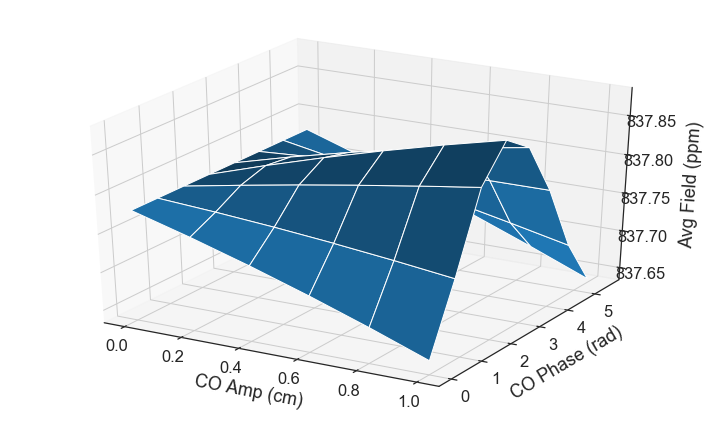

In [13]:
As = np.array(As)
As = As.reshape(6,8)
phis = np.array(phis)
phis = phis.reshape(6,8)
fields = np.array(fields)
fields = fields.reshape(6,8)

fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(As, phis, fields/61.79)

ax.set_xlabel('\nCO Amp (cm)')
ax.set_ylabel('\nCO Phase (rad)')
ax.set_zlabel('\n\nAvg Field (ppm)')

fig.set_size_inches(10,6)
fig.tight_layout()